# Dog breed classification

## Data exploration

In [2]:
import csv
import matplotlib.pylab as plt
import os
from keras.applications.resnet50 import ResNet50
import numpy as np
import PIL

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data distrubution

### Load data

In [3]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image 

import numpy as np
from glob import *
from PIL import ImageFile  
from tqdm import tqdm
     


In [9]:
def load_dataset(path, size=133):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), size)
    return dog_files, dog_targets

def path_to_tensor(img_path, size=224):
    img = image.load_img(img_path, target_size=(size, size))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

### Global variables

#### complete dataset

In [7]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
train_files_name = "dogImages/train"
test_file_name = "dogImages/test"
dog_names = [item[16:-1] for item in sorted(glob(train_files_name + "/*/"))]

In [10]:
# load data
train_files, train_targets = load_dataset(train_files_name)
test_files, test_targets = load_dataset(test_file_name)

# parse tensors
train_tensors = paths_to_tensor(train_files)
test_tensors = paths_to_tensor(test_files)

#### small dataset

In [115]:
train_files_small_name = "dataset_small/train"
test_file_small_name = "dataset_small/test"
dog_names_small = [item[16:-1] for item in sorted(glob(train_files_small_name + "/*/"))]


In [105]:
train_files_small, train_targets_small = load_dataset(train_files_small_name, 10)
test_files_small, test_targets_small = load_dataset(test_file_small_name, 10)

In [106]:
train_tensors_cnn = paths_to_tensor(train_files_small).astype('float32')/255
test_tensors_cnn = paths_to_tensor(test_files_small).astype('float32')/255

100%|██████████| 870/870 [00:05<00:00, 149.32it/s]


## CNN from scratch

### Model

In [116]:
def cnn_from_scratch(train_tensors, train_targets):
    # set the model
    model = Sequential()

    drop1 = 0.25     
    drop2 = 0.5      
    d_act = 'relu'   
    d_pad = 'same'   
    reg = l2(1e-3)
    

    model = Sequential()
    model.add(Conv2D(16, 2, input_shape=train_tensors.shape[1:], padding=d_pad, activation=d_act, kernel_regularizer=reg, name='block1_conv1'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, 2, padding=d_pad, activation=d_act, kernel_regularizer=reg, name='block2_conv1'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, 2, padding=d_pad, activation=d_act, kernel_regularizer=reg, name='block3_conv1'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(drop1))
    model.add(Flatten())
    model.add(Dense(512, activation=d_act, kernel_regularizer=reg))
    model.add(Dropout(drop2))
    model.add(Dense(len(dog_names_small), activation='softmax'))

    model.summary()
    
    # compile 
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    # train
    epochs = 20
    model.fit(train_tensors, train_targets, epochs=epochs, batch_size=20, verbose=1)
    
    return model

In [118]:
cnn_model = cnn_from_scratch(train_tensors_cnn, train_targets_small)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 28, 28, 64)        0         
__________

### Accuracy

In [154]:
def cnn_predict(model, test_tensors):
    return  [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

In [168]:
def cacl_cnn_accuracy(predictions, test_target):
    p = [i for i in np.argmax(train_targets_small,axis = 1)]
    c = 0
    for i in range(len(predictions)):
        if (predictions[i] == p[i]):
            c += 1

    test_accuracy = 100 * c /len(predictions)
    return test_accuracy
    

In [171]:
cnn_predicitons = cnn_predict(cnn_model, test_tensors_cnn)
cnn_accuracy = cacl_cnn_accuracy(cnn_predicitons, test_targets_small)
print('Test accuracy: %.4f%%' % cnn_accuracy)

107
870
Test accuracy: 12.2989%


## Transfer learning

### Extract features from ResNet50

In [42]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [45]:
def extract_Resnet50(tensor):
    from keras.applications.resnet50 import ResNet50, preprocess_input
    return ResNet50(weights='imagenet', include_top=False, pooling="avg").predict(preprocess_input(tensor))

In [14]:
def expand_dimensions(f):
    f = np.expand_dims(f, axis=1)
    f = np.expand_dims(f, axis=1)
    return f

In [ ]:
# extract feature
train_features_resnet50 = extract_Resnet50(train_tensors)
test_features_resnet50 = extract_Resnet50(test_tensors)

# expand dimensions
train_features_resnet50 = expand_dimensions(train_features_resnet50)
test_features_resnet50 = expand_dimensions(test_tensors)

# save as npz file
np.savez_compressed('resnet50data',test=test_features_resnet50, train = train_features_resnet50)

In [15]:
resnet50Data = np.load('resnet50data.npz')
resnet50Train = resnet50Data['train']
resnet50Test = resnet50Data['test']
resnet50Train = expand_dimensions(resnet50Train)
resnet50Test = expand_dimensions(resnet50Test)

In [21]:
tt = np.load('DogResnet50Data.npz')
resnet50Test = tt['test']

### extract features from Xception

In [ ]:
def extract_xception(tensor):
    from keras.applications.xception import Xception, preprocess_input
    return Xception(weights='imagenet', include_top=False, pooling="avg").predict(preprocess_input(tensor))

In [11]:
xceptionData = np.load('xceptionData.npz')
xceptionTrain = xceptionData['train']
xceptionTest = xceptionData['test']

### Train model

### resnet50

In [11]:
def tranfer_learning(trainingData, trainLabels, length):
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=trainingData.shape[1:]))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(length, activation='softmax'))

    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    model.fit(trainingData, trainLabels, epochs=10, batch_size=20, verbose=1)
    return model

In [16]:
resnet_model = tranfer_learning(resnet50Train, train_targets, len(dog_names))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               133133    
Total params: 2,182,133
Trainable params: 2,182,133
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6680/6680 [==============================] - 10s 2ms/step - loss: 2.4464 - acc: 0.4307
Epoch 2/10
6680/6680 [==============================] - 10s 1ms/step - loss: 1.0925 - acc: 0.6945
Epoch 3/10
6680/6680 [==============================] - 9s 1ms/step 

### Xception

In [12]:
def Xception_transfer_learning(trainingData,trainLabels,length):
    Xception_model = Sequential()
    Xception_model.add(GlobalAveragePooling2D(input_shape=trainingData.shape[1:]))
    Xception_model.add(Dense(1000, activation='relu'))
    Xception_model.add(Dropout(0.5))
    Xception_model.add(Dense(length, activation='softmax'))

    Xception_model.summary()
    Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    Xception_model.fit(trainingData, trainLabels,epochs=20, batch_size=40, verbose=1)
    return Xception_model 

In [13]:
Xception_model = Xception_transfer_learning(xceptionTrain,train_targets,len(dog_names))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               133133    
Total params: 2,182,133
Trainable params: 2,182,133
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6680/6680 [==============================] - 14s 2ms/step - loss: 1.4489 - acc: 0.6504
Epoch 2/20
6680/6680 [==============================] - 6s 962us/step - loss: 0.6889 - acc: 0.7934
Epoch 3/20
6680/6680 [==============================] - 7s 981us/st

### Test accuracy

In [14]:
def calculate_accuracy(model, testData, testLabel, m):
    i = 0
    a = 0
    for test in testData:
        arr = model.predict(np.expand_dims(test,axis = 0))
        idx = np.argsort(-arr[0])[:m]
        if np.argmax(testLabel[i]) in idx:
            a += 1
        i += 1
    return a/len(testLabel)

In [22]:
# test accuracy
m = 3
acc = calculate_accuracy(resnet_model, resnet50Test, test_targets, m)
print(acc)

0.9605263157894737


In [ ]:
m = 3
acc = calculate_accuracy(Xception_model, resnet50Test, test_targets, m)
print(acc)

## Prediction

In [56]:
def make_prediction(dog_names, model, testData, m):
    labelList = []
    
    for test in testData:
        arr = model.predict(np.expand_dims(test,axis = 0))
        idx = np.argsort(-arr[0])[:m]
        l = [dog_names[index] for index in idx]
        labelList.append(l)
        
    return labelList

In [57]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

def show_sample(name):
    pp, ax = plt.subplots()
    print(name[4:])
    path = "dogImages/train/{0}/*".format(name)
    
    path = glob(path)[0]
    
    img = mpimg.imread(path)
    pp = ax.imshow(img)        
    plt.axis('off')
    plt.show()

In [188]:
def show_pic(path):
    pp, ax = plt.subplots()
    img = mpimg.imread(path)
    pp = ax.imshow(img)        
    plt.axis('off')
    plt.show()

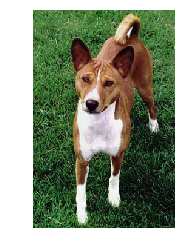

In [189]:
show_pic('testImage/test/014.Basenji/Basenji_01009.jpg')

In [194]:
def preprocess(path, npz_name):
    files, targets = load_dataset(path)
    tensors = paths_to_tensor(files)
    features_resnet50 = extract_Resnet50(tensors)
    features_resnet50 = expand_dimensions(features_resnet50)
    
    return files, features_resnet50

In [192]:
def resnet50_predictor(dog_names, path, name, model, m=3):
    files, features = preprocess(path, name)
    
    predictions = make_prediction(dog_names, model, features, m)
    for i in range(len(predictions)):
        print(files[i])
        show_pic(files[i])
        
        print("Top 3 matches are: ", " ".join(predictions[i]))

        show_sample(predictions[i][0])

100%|██████████| 9/9 [00:00<00:00, 69.64it/s]

['testImage/test/014.Basenji/Basenji_01009.jpg'
 'testImage/test/014.Basenji/Basenji_00961.jpg'
 'testImage/test/014.Basenji/Basenji_00959.jpg'
 'testImage/test/014.Basenji/Basenji_00978.jpg'
 'testImage/test/014.Basenji/Basenji_01029.jpg'
 'testImage/test/014.Basenji/Basenji_00987.jpg'
 'testImage/test/014.Basenji/Basenji_00974.jpg'
 'testImage/test/014.Basenji/Basenji_00955.jpg'
 'testImage/test/014.Basenji/Basenji_00985.jpg']


testImage/test/014.Basenji/Basenji_01009.jpg


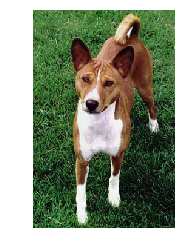

Top 3 matches are:  014.Basenji 045.Cardigan_welsh_corgi 118.Pembroke_welsh_corgi
Basenji


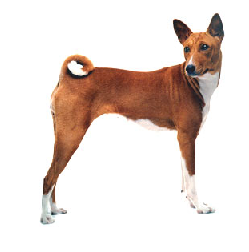

testImage/test/014.Basenji/Basenji_00961.jpg


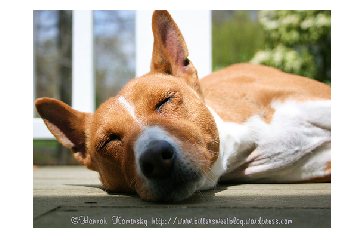

Top 3 matches are:  014.Basenji 004.Akita 043.Canaan_dog
Basenji


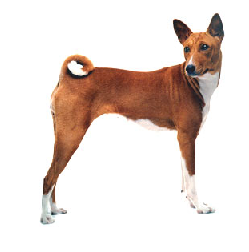

testImage/test/014.Basenji/Basenji_00959.jpg


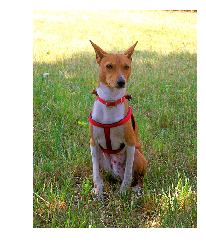

Top 3 matches are:  014.Basenji 116.Parson_russell_terrier 118.Pembroke_welsh_corgi
Basenji


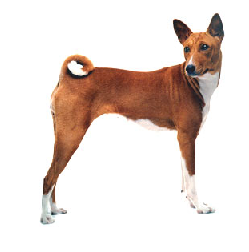

testImage/test/014.Basenji/Basenji_00978.jpg


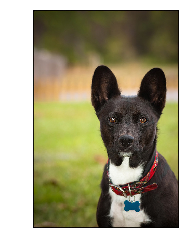

Top 3 matches are:  014.Basenji 045.Cardigan_welsh_corgi 069.French_bulldog
Basenji


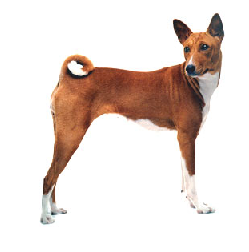

testImage/test/014.Basenji/Basenji_01029.jpg


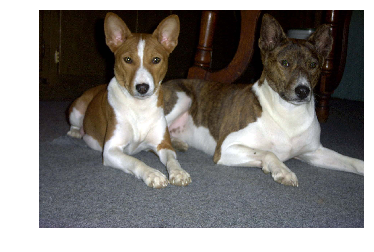

Top 3 matches are:  014.Basenji 083.Ibizan_hound 039.Bull_terrier
Basenji


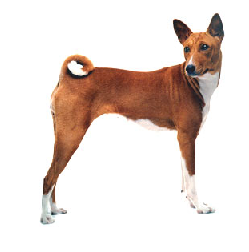

testImage/test/014.Basenji/Basenji_00987.jpg


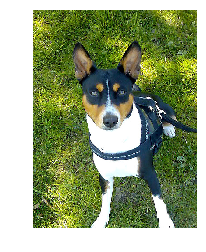

Top 3 matches are:  014.Basenji 116.Parson_russell_terrier 043.Canaan_dog
Basenji


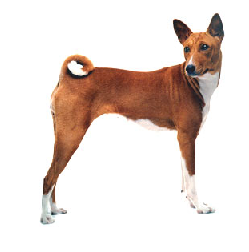

testImage/test/014.Basenji/Basenji_00974.jpg


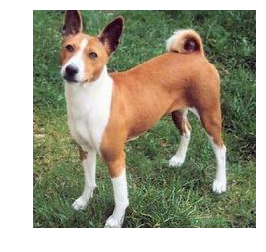

Top 3 matches are:  014.Basenji 004.Akita 043.Canaan_dog
Basenji


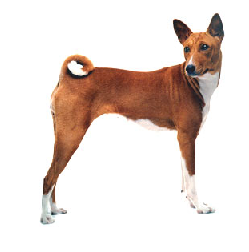

testImage/test/014.Basenji/Basenji_00955.jpg


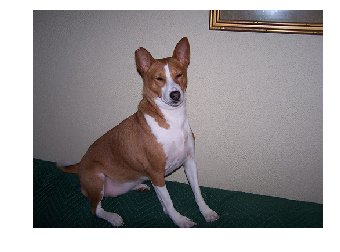

Top 3 matches are:  014.Basenji 083.Ibizan_hound 045.Cardigan_welsh_corgi
Basenji


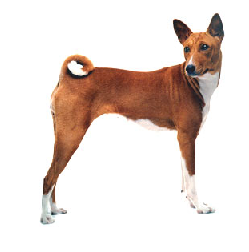

testImage/test/014.Basenji/Basenji_00985.jpg


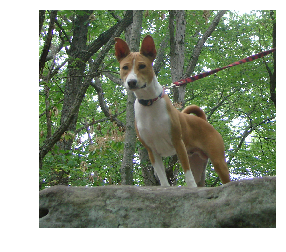

Top 3 matches are:  014.Basenji 083.Ibizan_hound 081.Greyhound
Basenji


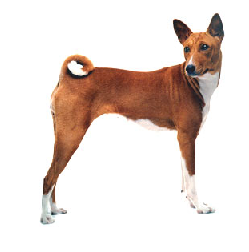

In [193]:
dog_dir = "testImage/test"
resnet50_predictor(dog_names, dog_dir , 'dog_feature', resnet_model)

In [179]:
print(glob(e+'/*/') for e in[p for p in glob(dog_dir + "/*/")])

<generator object <genexpr> at 0x1ae0c3e2b0>
